# Non-Linear Time History Analysis (NLTHA) on Single Degree of Freedom (SDOF) Oscillators

In this method, a single degree of freedom (SDOF) model of each structure is subjected to non-linear time history analysis (NLTHA) using a suite of ground motion records. The displacements of the SDOF due to each ground motion record are used as input to determine the distribution of buildings in each damage state for each level of ground motion intensity. A regression algorithm is then applied to derive the fragility model.

The figure below illustrates a fragility model developed using this method.

<img src="../../../../figures/NLTHA_SDOF.png" width="400" align="middle">

**Note**: To run the code in a cell:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

In [1]:
from rmtk.vulnerability.common import utils
from rmtk.vulnerability.derivation_fragility.NLTHA_on_SDOF import NLTHA_on_SDOF
from rmtk.vulnerability.derivation_fragility.NLTHA_on_SDOF.read_pinching_parameters import read_parameters
%matplotlib inline

---
### Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format described in the [RMTK manual](../../../../rmtk-docs.pdf).

Please provide the location of the file containing the capacity curves using the parameter `capacity_curves_file`.

In [2]:
capacity_curves_file = "../../../../sample_data/capacity_curves_point.csv"
sdof_hysteresis = "Default"
#sdof_hysteresis = "../../../../../rmtk_data/pinching_parameters.csv"

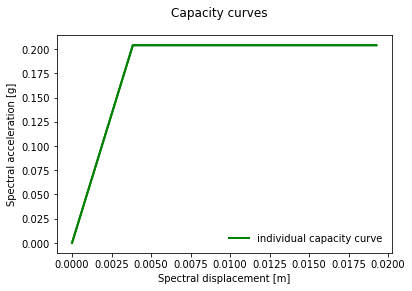

In [3]:
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)
hysteresis = read_parameters(sdof_hysteresis)

### Load ground motion records

Please indicate the path to the folder containing the ground motion records to be used in the analysis through the parameter `gmrs_folder`.

**Note**: Each accelerogram needs to be in a separate CSV file as described in the [RMTK manual](../../../../rmtk-docs.pdf).

The parameters `minT` and `maxT` are used to define the period bounds when plotting the spectra for the provided ground motion fields.

/Users/vitorsilva/python36env/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


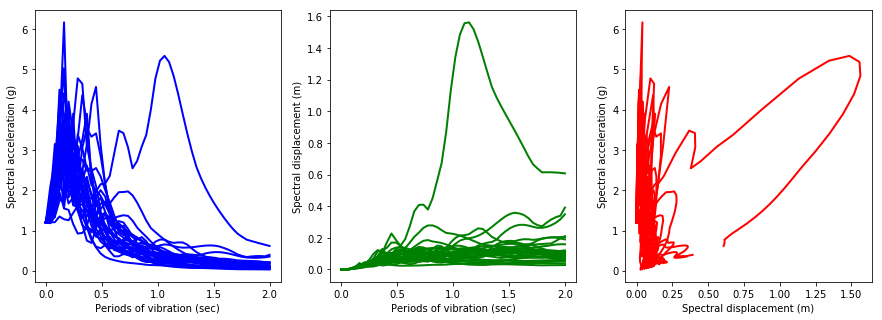

In [4]:
gmrs_folder = '../../../../sample_data/accelerograms'
minT, maxT = 0.0, 2.0
gmrs = utils.read_gmrs(gmrs_folder)
#utils.plot_response_spectra(gmrs, minT, maxT)

### Load damage state thresholds

Please provide the path to your damage model file using the parameter `damage_model_file` in the cell below.

The damage types currently supported are: `capacity curve dependent`, `spectral displacement` and `interstorey drift`. If the damage model type is `interstorey drift` the user can provide the pushover curve in terms of Vb-dfloor to be able to convert interstorey drift limit states to roof displacements and spectral displacements, otherwise a linear relationship is assumed.

In [5]:
damage_model_file = "../../../../sample_data/damage_model.csv"
damage_model = utils.read_damage_model(damage_model_file)

['Slight', 'Sdy', 'normal', '', '0']
['Moderate', '2 Sdy 1 Sdu', 'normal', '', '0']
['Extensive', '1 Sdy 2 Sdu', 'normal', '', '0']
['Collapse', 'Sdu', 'normal', '', '0']


### Obtain the damage probability matrix

The following parameters need to be defined in the cell below in order to calculate the damage probability matrix:
1. `damping_ratio`: This parameter defines the damping ratio for the structure.
2. `degradation`: This boolean parameter should be set to `True` or `False` to specify whether structural degradation should be considered in the analysis or not.

In [6]:
damping_ratio = 0.05
degradation = True
[PDM,Sds]= NLTHA_on_SDOF.calculate_response(capacity_curves, hysteresis, gmrs, damage_model, damping_ratio, degradation)
utils.plotIMEDP(gmrs,T,Sds,'log')
[extendedResponse] = utils.addShakingVaribility(PDM,COV)
utils.save_result(PDM,'../../../../sample_data/PDM.csv')

100.0%
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


### Find an adequate intensity measure

This sections allows users to find an intensity measure (PGA or Spectral Acceleration) that correlates well with damage. To do so, it is necessary to establish a range of periods of vibration and step (`minT`, `maxT` and `stepT`).


In [8]:
minT, maxT,stepT  = 0.0, 2.0, 0.1
regression_method = 'cloud analysis'
utils.evaluate_optimal_IM(gmrs,PDM,minT,maxT,stepT,damage_model,damping_ratio,regression_method,capacity_curves)

5.0%


/Users/vitorsilva/Dropbox/GEM/git/gem/rmtk/rmtk/vulnerability/common/utils.py:621: RuntimeWarning: divide by zero encountered in log
  y_vec=np.log(Sds)
/Users/vitorsilva/Dropbox/GEM/git/gem/rmtk/rmtk/vulnerability/common/utils.py:650: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(p))
/Users/vitorsilva/python36env/lib/python3.6/site-packages/scipy/optimize/optimize.py:570: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


/Users/vitorsilva/Dropbox/GEM/git/gem/rmtk/rmtk/vulnerability/common/utils.py:656: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(p1))-np.sum(np.log(p2))


10.0%


/Users/vitorsilva/Dropbox/GEM/git/gem/rmtk/rmtk/vulnerability/common/utils.py:667: RuntimeWarning: invalid value encountered in double_scalars
  ssto[i]=(y_vec[i]-np.mean(y_vec,dtype=float))**2


15.0%
20.0%
25.0%
30.0%
35.0%
40.0%
45.0%
50.0%
55.0%
60.0%
65.0%
70.0%
75.0%
80.0%
85.0%
90.0%
95.0%
100.0%


IndexError: tuple index out of range

### Fit lognormal CDF fragility curves

The following parameters need to be defined in the cell below in order to fit lognormal CDF fragility curves to the damage probability matrix obtained above:
1. `IMT`: This parameter specifies the intensity measure type to be used. Currently supported options are `"PGA"`, `"Sa"` and `"Sd"`.
2. `T`: This parameter defines the time period of the fundamental mode of vibration of the structure.
3. `regression_method`: This parameter defines the regression method to be used for estimating the parameters of the fragility functions. The valid options are "cloud analysis", "least squares" and "max likelihood".

In [14]:
IMT = "Sa"
T = 0.7
#utils.export_IMLs_PDM(gmrs,T,PDM,damping_ratio,damage_model,'../../../../../rmtk_data/IMLs_PDM.csv')
response=[PDM,Sds]
fragility_model = utils.calculate_mean_fragility(gmrs,response, T, damping_ratio,IMT, damage_model, regression_method,capacity_curves)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 15
         Function evaluations: 60


### Plot fragility functions

The following parameters need to be defined in the cell below in order to plot the lognormal CDF fragility curves obtained above:
* `minIML` and `maxIML`: These parameters define the limits of the intensity measure level for plotting the functions

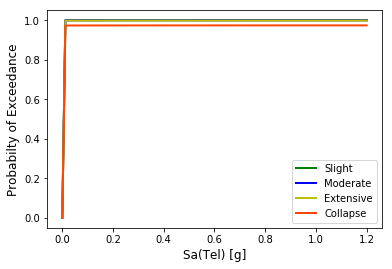

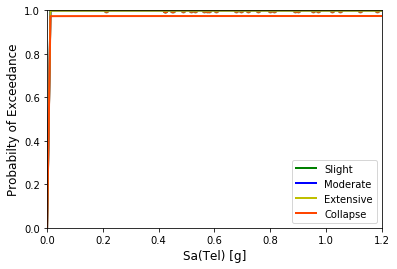

In [15]:
minIML, maxIML = 0.0, 1.2
utils.plot_fragility_model(fragility_model, minIML, maxIML)
utils.plot_fragility_scatter(fragility_model, minIML, maxIML, PDM, gmrs, IMT, T, damping_ratio)

### Save fragility functions

The derived parametric fragility functions can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
2. `minIML` and `maxIML`: These parameters define the bounds of applicability of the functions.
3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [ ]:
taxonomy = "RC"
minIML, maxIML = 0.01, 2.00
output_type = "csv"
output_path = "../../../../../rmtk_data/output/"
utils.save_mean_fragility(taxonomy, fragility_model, minIML, maxIML, output_type, output_path)

### Obtain vulnerability function

A vulnerability model can be derived by combining the set of fragility functions obtained above with a consequence model. In this process, the fractions of buildings in each damage state are multiplied by the associated damage ratio from the consequence model, in order to obtain a distribution of loss ratio for each intensity measure level. 

The following parameters need to be defined in the cell below in order to calculate vulnerability functions using the above derived fragility functions:
1. `cons_model_file`: This parameter specifies the path of the consequence model file.
2. `imls`: This parameter specifies a list of intensity measure levels in increasing order at which the distribution of loss ratios are required to be calculated.
3. `distribution_type`: This parameter specifies the type of distribution to be used for calculating the vulnerability function. The distribution types currently supported are "lognormal", "beta", and "PMF".

In [ ]:
cons_model_file = "../../../../../rmtk_data/cons_model.csv"
imls = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 
        0.60, 0.70, 0.80, 0.90, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00, 
        2.20, 2.40, 2.60, 2.80, 3.00, 3.20, 3.40, 3.60, 3.80, 4.00]
distribution_type = "lognormal"
cons_model = utils.read_consequence_model(cons_model_file)
vulnerability_model = utils.convert_fragility_vulnerability(fragility_model, cons_model, 
                                                            imls, distribution_type)

### Plot vulnerability function

In [ ]:
utils.plot_vulnerability_model(vulnerability_model)

### Save vulnerability function

The derived parametric or nonparametric vulnerability function can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [ ]:
taxonomy = "RC"
output_type = "csv"
output_path = "../../../../../rmtk_data/output/"
utils.save_vulnerability(taxonomy, vulnerability_model, output_type, output_path)